<a href="https://colab.research.google.com/github/foubari/Binded-VAE/blob/main/Binded_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [20]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline

Use GPU On Colab

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

In [12]:
BATCH_SIZE = 512
# path = <dataset_path>
#bvae_dataset = pd.read_csv(path).sample(frac=1)
#bvae_dataset = tf.convert_to_tensor(bvae_dataset.astype('float32')) 
#mask_dataset=np.where(bvae_dataset > 0, 1.0, 0.0).astype('float32')
#mask_generator = tf.data.Dataset.from_tensor_slices(mask_dataset).shuffle(True).batch(BATCH_SIZE)
#train_set = tf.data.Dataset.from_tensor_slices((bvae_dataset,mask_dataset))
#train_set = train_set.shuffle(True).batch(BATCH_SIZE)

# Model

## Parameters

In [15]:
lr = 0.001
data_dim = 100 # Replace with bvae_dataset.shape[1] 
latent_dim1=64
latent_dim2=32
r_lambda1=10
r_lambda2=1
dice_gamma=10
beta=10

## Binded VAE

In [16]:
class Binded_vae(keras.Model):
    def __init__(self,data_dim,latent_dim1,latent_dim2,r_lambda1,r_lambda2,dice_gamma,beta):
        super(Binded_vae,self).__init__()
        
        self.latent_dim1= latent_dim1 
        self.latent_dim2= latent_dim2
        self._lambda1 = r_lambda1
        self._lambda2 = r_lambda2
        self._dice_gamma=dice_gamma
        self._beta = beta
        self._output_dim = data_dim 
        
        self.m_encoder = keras.Sequential([keras.layers.Dense(512, activation = 'relu'),
                                          keras.layers.Dense(1024, activation = 'relu'),
                                          keras.layers.Dense(256, activation = 'relu'),
                                          keras.layers.Dense(2*self.latent_dim1, activation = 'linear'),])
        
        self.m_decoder = keras.Sequential([keras.layers.Dense(512, activation = 'relu'),
                                           keras.layers.Dense(1024, activation = 'relu'),
                                           keras.layers.Dense(256, activation = 'relu'),
                                           keras.layers.Dense(self._output_dim, activation = 'sigmoid')])
        
        self.r_encoder = keras.Sequential([keras.layers.Dense(256, activation = 'relu'),
                                          keras.layers.Dense(2*self.latent_dim2, activation = 'linear'),])
        
        self.r_decoder = keras.Sequential([keras.layers.Dense(256, activation = 'relu'),
                                          keras.layers.Dense(self._output_dim, activation = 'sigmoid'),])
        
        
    
    def m_encode(self, x):
        z_mean,z_log_var = tf.split(self.m_encoder(x), num_or_size_splits=2, axis=1)
        return z_mean,z_log_var
    
    def m_decode(self,x):
        return self.m_decoder(x)
    
    def m_sample(self, z_mean, z_log_var, batch_size):
        epsilon = tf.random.normal(shape=(batch_size,self.latent_dim1))
        return z_mean +  tf.exp(0.5*z_log_var)*epsilon
    
    def dice(self,a,b):
        return -2*tf.reduce_sum(a*b)/tf.reduce_sum(a+b)

    def m_loss(self ,z_mean, z_log_var, data, reconstruction):
        r_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data,reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        dice_loss = self.dice(data,reconstruction)
        return    self._lambda1*r_loss + tf.reduce_mean(kl_loss)+self._dice_gamma*dice_loss
    
    def r_encode(self, x,x_mask):
        x_concat = tf.concat((x,x_mask),axis=1)
        z_mean,z_log_var = tf.split(self.r_encoder(x_concat), num_or_size_splits=2, axis=1)
        return z_mean,z_log_var

    def r_decode(self,x,x_mask):
        x_concat = tf.concat((x,x_mask),axis=1)
        return self.r_decoder(x_concat)

    def r_sample(self, z_mean, z_log_var, batch_size):
        epsilon = tf.random.normal(shape=(batch_size,self.latent_dim2))
        return z_mean +  tf.exp(0.5*z_log_var)*epsilon

    def r_loss(self ,z_mean, z_log_var,data,data_mask,values):
        r_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data,data_mask*values))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))    
        return  self._lambda2*r_loss + tf.reduce_mean(kl_loss)

    def bvae_loss(self,cz_mean, cz_log_var,bz_mean, bz_log_var,data,data_mask, reconstruction,values):
        r_vae_loss = self.r_loss(cz_mean, cz_log_var, data,reconstruction,values)
        m_vae_loss = self.m_loss(bz_mean, bz_log_var, data_mask, reconstruction)
        return  r_vae_loss+self._beta*m_vae_loss,m_vae_loss,r_vae_loss    

    def train_step(self,data):
        data,data_mask = data
        with tf.GradientTape() as tape:
            mz_mean, mz_log_var = self.m_encode(data_mask)
            msample = self.m_sample(mz_mean, mz_log_var, tf.shape(data)[0])
            reconstruction = self.m_decode(msample)          
            
            rz_mean, rz_log_var = self.r_encode(data,reconstruction)
            rsample = self.r_sample(rz_mean, rz_log_var, tf.shape(data)[0])
            values = self.r_decode(rsample,reconstruction)           
            
            losses = self.bvae_loss(rz_mean, rz_log_var,mz_mean, mz_log_var,data,data_mask, reconstruction,values)  
            loss = losses[0]
            loss_grad = tape.gradient(loss,self.trainable_variables)
            self.optimizer.apply_gradients(zip(loss_grad,self.trainable_variables))        

                        
        return {"Total loss": loss,"Mask loss": losses[1],"Values loss": losses[2]}

## Train model

In [ ]:
bvae = Binded_vae(latent_dim1,latent_dim2,r_lambda1,r_lambda2,dice_gamma,beta)
bvae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
#bvae_train_hist = bvae.fit(x=train_set,batch_size =BATCH_SIZE,epochs=100)

### Plot losses

In [ ]:
''' Plot losses'''
#fig= plt.subplots( figsize=(5,5))
#plt.plot(bvae_train_hist.history['Total loss'],label = 'Total loss')     
#plt.plot(bvae_train_hist.history['Mask loss'],label = "Mask loss")
#plt.plot(bvae_train_hist.history['Values loss'],label = "Value loss")  
#plt.legend()
#plt.show()

# New generations

In [28]:
'''Generate new compounds'''
def generate(n=10000):
    mask_sample,ratio_sample = tf.random.normal((n,latent_dim1)),tf.random.normal((n,latent_dim2))
    mask=bvae.m_decoder.predict(mask_sample)
    generated_data = mask*bvae.r_decoder.predict(tf.concat((ratio_sample,mask),axis=1))
    return generated_data,mask
generated_data,mask= generate(10000) 

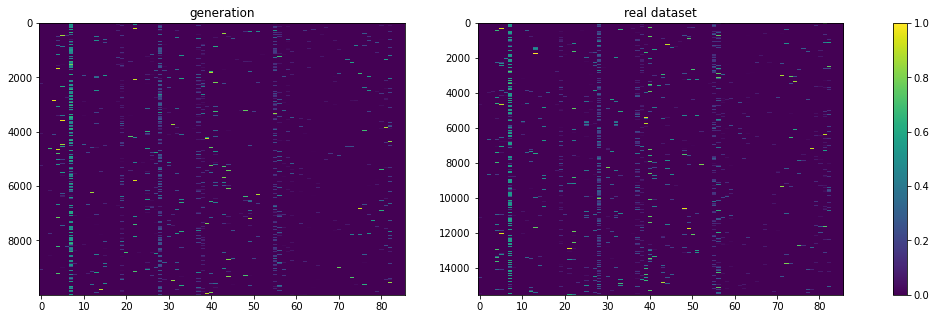

In [29]:
''' Plot generations next to real data'''
plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(hspace=.5)
im = ax[0].imshow(generated_data, aspect='auto',interpolation='nearest',cmap=plt.get_cmap('viridis'))   
ax[0].set_title('generation')
im = ax[1].imshow(bvae_dataset, aspect='auto',interpolation='nearest',cmap=plt.get_cmap('viridis'))
ax[1].set_title('real dataset')
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
''' Save and load model'''
#bvae.save_weights('model_path')
#bvae.load_weights('model_path')